# Homework 11 - Voice of Customers
**Subject:** BADS 7205 - CRM Analytics and Intelligence  
**Student:** Tanat Iempreedee (6210422036)

## **Initialization**

In [33]:
!pip install --upgrade pythainlp
!pip install pyLDAvis
!pip install sefr_cut
# !pip install deepcut
# !pip install tensorflow_text

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached numpy-1.25.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.


  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is incompatible.


In [34]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import re
import string
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


import pythainlp
from pythainlp.tokenize import sent_tokenize, word_tokenize
import gensim

import sefr_cut
sefr_cut.load_model(engine='tl-deepcut-ws1000')
# sefr_cut.load_model(engine='ws1000')


# import tensorflow_hub as hub
# import tensorflow_text
# import tensorflow as tf

import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()


loading model.....


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Success


In [65]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('/content/K2D-Regular.ttf')
mpl.rc('font', family='K2D', size=12, weight=200)

## **Load dataset**

In [36]:
df = pd.read_csv('Review.csv')
df.tail()

,Restaurant,user,headline,review,rating
11,เฟิงฟู่หม่าล่า หม้อไฟ,chubbypenguinvy,เฟิงฟู่หม่าล่าหม้อไฟ,ในส่วนของวัตถุดิบก็ยังเหมือนกับร้านเฟิงฟู่หม่า...,3
12,หม่าล่าอาอี๋ บรรทัดทอง,Kalphapon Polwacharapat,หม่าล่าOriginal รสเด็ด,ร้านหม่าล่าจากจีน เชฟคนจีน หม่าล่าเผ็ดน้อยอร่อ...,4
13,หม่าล่าอาอี๋ บรรทัดทอง,Nongnong Visa Wangsuphachart,หม่าล่าหอมชาสะใจ เนื้อวัวและเนื้อแกะดีมาก,หม่าล่าแบบจีนแท้ๆจากเฉิงตู ซุปหอมมาก ชอบแกะมาก...,5
14,หม่าล่าอาอี๋ บรรทัดทอง,Padipat.N,หม่าล่ามาอี๋,พอดีหาร้านแซ่บๆ หม่าล่าทานเจอร้านนี้เลยมาแวะทา...,4
15,หม่าล่าอาอี๋ บรรทัดทอง,kouinteyvat,หม่าล่าบรรทัดมอง,หม่าล่าดี ซุปมะเขือเทศดี แต่พอเติมน้ำไปซัก 3 ร...,5


##**Text preprocessing**

In [68]:
# text cleansing
def cleanse_text(text):

    text = text.strip().lower()

    for old,new in correction_dict.items():
        text = text.replace(old, new)

    # remove empty spaces
    text = re.sub(r'\u200b', '', text)

    # replace punctuations with a space
    text = re.sub(r'[ๆฯ!#$&%\"\'()*+,-./:;<=>?@\[\]\\^_`{}|~]',' ', text)

    # replace numbers with a space
    text = re.sub(r'\d',' ', text)

    # replace whitespaces with a space
    # text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleansed_text'] = df.apply(lambda x: cleanse_text(x['headline'] + ' ' + x['review']), axis=1)

# sentence & word tokenization
df['tokens'] = df['cleansed_text'].apply(lambda x: [ w for st in sent_tokenize(x, engine='whitespace+newline') for w in sefr_cut.tokenize(st,k=100)])

# flatten & remove stop words
stopwords = list(pythainlp.corpus.thai_stopwords())
screening_words = stopwords

df['tokens'] = df['tokens'].apply(lambda x: [ w for sublist in x for w in sublist if w not in screening_words])

df.loc[:5, 'tokens']

1/1 [==============================] - 0s 26ms/step


0    [สุกี้, สายพาน, หม้อ, เดี่ยว, เจ้าดัง, น้ำจิ้ม...
1    [สุกี้, หม่า, ล่า, หม้อ, เดี่ยว, ตอน, เลือก, แ...
2    [คิว, ว่าง, แวะ, น้ำ, ซุป, เลือก, น้ำจิ้ม, รสช...
3    [คิว, สุ่ม, น้ำจิ้ม, นัว, เครื่อง, เนื้อ, เลือ...
4    [อี้, จาสุกี้, หม่าล่า, บรรทัดทอง, อี้, จาสุกี...
5    [สุกี้, สายพาน, ฮิต, กิน, ฮิต, ตอน, หนี, พ้น, ...
Name: tokens, dtype: object

In [38]:
data_words = df['tokens']
min_count = 1
threshold = 1

bigram = gensim.models.Phrases(data_words, min_count=min_count, threshold=threshold)
trigram = gensim.models.Phrases(bigram[data_words], min_count=min_count, threshold=threshold)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# trigram_mod[data_words[3]]
df['trigram_mod'] = trigram_mod[data_words]
df.head()

,Restaurant,user,headline,review,rating,cleansed_text,tokens,trigram_mod
0,สุกี้จินดา ลาดพร้าว - วังหิน,PookEats,สุกี้สายพานหม้อเดี่ยวเจ้าดัง น้ำจิ้มสูตรของร้า...,จากที่ได้ชิม ชอบน้ำซุปและน้ำจิ้ม เข้มข้นอร่อยด...,4,สุกี้สายพานหม้อเดี่ยวเจ้าดัง น้ำจิ้มสูตรของร้า...,"[สุกี้, สายพาน, หม้อ, เดี่ยว, เจ้าดัง, น้ำจิ้ม...","[สุกี้, สายพาน, หม้อ, เดี่ยว, เจ้าดัง, น้ำจิ้ม..."
1,สุกี้จินดา ลาดพร้าว - วังหิน,Lzyfooddiary,สุกี้หม่าล่าหม้อเดี่ยวที่ดังสุดในตอนนี้,ที่นี่มีของให้เลือกเยอะมาก แยกด้วยสีต่างๆ 5 10...,4,สุกี้หม่าล่าหม้อเดี่ยวที่ดังสุดในตอนนี้ ที่นี่...,"[สุกี้, หม่า, ล่า, หม้อ, เดี่ยว, แยก, สี, เสีย...","[สุกี้, หม่า_ล่า, หม้อ, เดี่ยว, แยก, สี, เสียบ..."
2,สุกี้จินดา ลาดพร้าว - วังหิน,aapon,คิวยาวมาก ไม่ว่างจริงไม่ต้องแวะมา,น้ำซุปมีให้เลือก หลายอย่างมาก น้ำจิ้มรสชาติอร่...,4,คิวยาวมาก ไม่ว่างจริงไม่ต้องแวะมา น้ำซุปมีให้เ...,"[คิว, ว่าง, แวะ, น้ำ, ซุป, น้ำจิ้ม, รสชาติ, อร...","[คิว, ว่าง, แวะ, น้ำ_ซุป, น้ำจิ้ม, รสชาติ, อร่..."
3,สุกี้จินดา ลาดพร้าว - วังหิน,taluidax,คิวแบบสุ่ม เร็วบ้างช้าบ้าง แล้วแต่วัน,น้ำจิ้มนัวๆ เครื่อง เนื้อมีให้เลือกเยอะ นั่งกั...,4,คิวแบบสุ่ม เร็วบ้างช้าบ้าง แล้วแต่วัน น้ำจิ้มน...,"[คิว, สุ่ม, น้ำจิ้ม, นัว, เครื่อง, เนื้อ, นั่ง...","[คิว, สุ่ม, น้ำจิ้ม, นัว, เครื่อง, เนื้อ, นั่ง..."
4,อี้จาสุกี้หม่าล่า สาขาบรรทัดทอง,EATaday,อี้จาสุกี้หม่าล่า บรรทัดทอง,อี้จาสุกี้หม่าล่า สาขาบรรทัดทอง อร่อยเด็ด กินไ...,4,อี้จาสุกี้หม่าล่า บรรทัดทอง อี้จาสุกี้หม่าล่า ...,"[อี้, จาสุกี้, หม่าล่า, บรรทัดทอง, อี้, จาสุกี...","[อี้, จาสุกี้, หม่าล่า, บรรทัดทอง, อี้, จาสุกี..."


In [39]:
df.to_pickle('prep.pkl')

## **Create Dictionary**

In [40]:
# documents = df['tokens'].to_list()
documents = df['trigram_mod'].to_list()
dictionary = gensim.corpora.Dictionary(documents)
pprint(str(dictionary.token2id.keys()))

("dict_keys(['คุ้ม', 'คุ้มเท่าทาน', 'ชอบ_น้ำ', 'ชิม', 'ซุป', 'ตอม', 'ถาด', "
 "'น้ำจิ้ม', 'บุฟเฟต์', 'ผัก', 'สะอาด', 'สัตว์', 'สายพาน', 'สุกี้', 'สูตร', "
 "'สไลด์', 'หม้อ', 'หู้', 'อร่อย', 'เข้มข้น', 'เครื่อง_ชอบ', 'เจ้าดัง', "
 "'เฉียบ', 'เดี่ยว', 'เต้า', 'เนื้อ', 'เมนู', 'แมลงวัน', 'portion', 'ดิบ', "
 "'วัตถุ', 'สด', 'สี', 'หมุน', 'หม่า_ล่า', 'หลาก', 'เติม', 'เวียน', 'เสียบ', "
 "'แยก', 'คิว', 'งาม', 'ชอบ', 'น้ำ_ซุป', 'รสชาติ', 'ว่าง', 'หมูเนื้อ', "
 "'เหนียว', 'แวะ', 'แฮมจีน', 'โดดเด่น', 'ไส้', 'ต้ม', 'นัว', 'นั่ง', 'น้ำซุป', "
 "'ประหยัด', 'สุ่ม', 'ส่วนัว', 'หวาน', 'เครื่อง', 'diy', 'จาสุกี้', 'ต้น', "
 "'บรรทัดทอง', 'ปรุง', 'สาขา', 'หม่าล่า', 'อี้', 'เด็ด', 'ไม้', 'ชิ้น', "
 "'นุ่มดี', 'ปลา', 'พ้น', 'ฟอง', 'ลูก', 'หนี', 'หมู', 'ฮิต', 'เต็ม', "
 "'เนื้อ_วัว', 'เนื้อร้าน', 'ระบบ', 'สับสน', 'แผ่ว', 'กลาง', 'ชำระ', 'ชู', "
 "'นุ่ม', 'บริการ', 'บ่าย', 'ปาน', 'ผง', 'รส', 'ระดับ', 'ราคา', 'สอง', "
 "'หม่าล่า_จีน', 'เงิน', 'แนะนำ', 'แน่น', 'แรง', 'แห่', 'โอน', 'ซอส', "
 "'ซุป_หม่า', 'ปก

In [41]:
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in documents]
word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]
id2word = dictionary.id2token

## **Topic Modeling**

### Evaluate number of topics

In [42]:
chunksize = 100 # size of the doc looked at every pass
passes = 20 # number of passes through documents #10
iterations = 100
eval_every = 1 # Don't evaluate model perplexity, takes too much time

# choosing n topics
score = []
for k in range(2,21):
    model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, \
                        alpha='auto', eta='auto', \
                        iterations=iterations, num_topics=k, \
                        passes=passes, eval_every=eval_every)
    coherence_model_lda = gensim.models.CoherenceModel(model=model, texts=df['trigram_mod'], dictionary=dictionary, coherence='c_v')
    score.append((k,coherence_model_lda.get_coherence(),model.log_perplexity(gensim_corpus)))


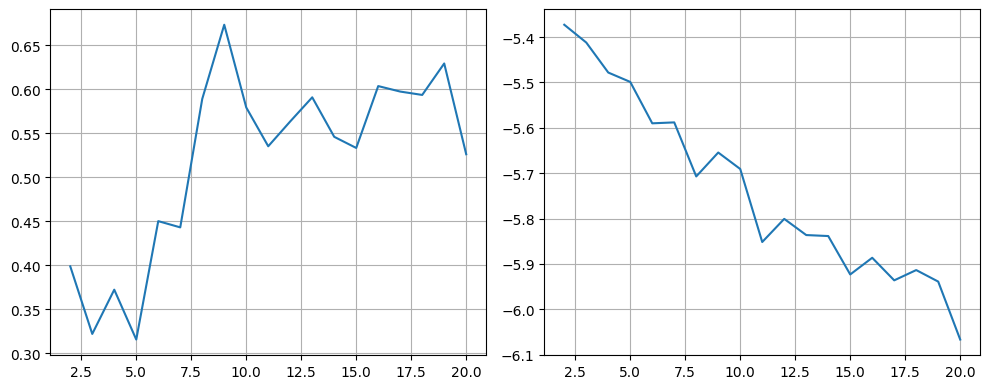

In [43]:
x, y, z = zip(*score)
# fig, axes = plt.subplots(1,2)
plt.figure(figsize=(10,4), tight_layout=True)
plt.subplot(121)
plt.plot(x, y, label='coherence score')
plt.grid(True)
plt.subplot(122)
plt.plot(x, z, label='perplexity')
plt.grid(True)
plt.show()

### Topic Modeling

In [44]:
num_topics = 4
chunksize = 100 # size of the doc looked at every pass
passes = 20 # number of passes through documents #10
iterations = 100
eval_every = 1 # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
temp = dictionary[0] # This is only to "load" the dictionary
id2word = dictionary.id2token

%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

CPU times: user 292 ms, sys: 1.85 ms, total: 294 ms
Wall time: 362 ms


In [45]:
pprint(model.print_topics(num_words=15))
doc_lda = model[gensim_corpus]

# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(gensim_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=model, texts=df['trigram_mod'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

[(0,
  '0.043*"หม่า_ล่า" + 0.018*"อร่อย_ซุป" + 0.018*"โอเค" + 0.018*"หม้อ" + '
  '0.018*"ไฟ" + 0.018*"วัตถุ" + 0.018*"เหมือน" + 0.018*"ดิบ" + 0.018*"ฟู่" + '
  '0.018*"เฟิง" + 0.010*"เต้า" + 0.010*"หู้" + 0.010*"น้ำจิ้ม" + '
  '0.010*"สายพาน" + 0.010*"ฟอง"'),
 (1,
  '0.060*"คิว" + 0.034*"หม่า_ล่า" + 0.034*"ชอบ" + 0.028*"อร่อย" + '
  '0.021*"สายพาน" + 0.021*"สุกี้" + 0.015*"สด" + 0.015*"แกะ" + 0.015*"ดิบ" + '
  '0.015*"วัตถุ" + 0.015*"รสชาติ" + 0.015*"ระบบ" + 0.015*"สับสน" + '
  '0.015*"เนื้อ" + 0.015*"เนื้อ_วัว"'),
 (2,
  '0.026*"อร่อย" + 0.021*"ต้ม" + 0.021*"หม่า_ล่า" + 0.021*"สายพาน" + '
  '0.021*"ซุป" + 0.016*"เนื้อ" + 0.016*"เงิน" + 0.016*"รสชาติ" + '
  '0.016*"น้ำจิ้ม" + 0.011*"น้ำ_ซุป" + 0.011*"น้ำ" + 0.011*"ชุป" + 0.011*"รส" '
  '+ 0.011*"ราคา" + 0.011*"ชิม"'),
 (3,
  '0.028*"น้ำจิ้ม" + 0.019*"อร่อย" + 0.019*"กุ้ง" + 0.019*"อี้" + '
  '0.019*"บรรทัดทอง" + 0.019*"ปรุง" + 0.019*"หม่าล่า" + 0.019*"จาสุกี้" + '
  '0.011*"สายพาน" + 0.011*"สด" + 0.011*"ต้น" + 0.011*"รอบ" + 0.011*"ทอด"

In [46]:
pyLDAvis.gensim_models.prepare(model, gensim_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.079401  0.031281       1        1  38.926787
1     -0.020020 -0.107986       2        1  26.303131
0      0.109006  0.008913       3        1  18.168356
3     -0.009585  0.067791       4        1  16.601726, topic_info=         Term       Freq      Total Category  logprob  loglift
40        คิว   7.000000   7.000000  Default  30.0000  30.0000
42        ชอบ   4.000000   4.000000  Default  29.0000  29.0000
34   หม่า_ล่า  10.000000  10.000000  Default  28.0000  28.0000
65       ปรุง   2.000000   2.000000  Default  27.0000  27.0000
194      กุ้ง   1.000000   1.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
25      เนื้อ   0.676853   4.668714   Topic4  -4.5348  -0.1355
78        หมู   0.676852   2.549358   Topic4  -4.5348   0.4695
4         ซุป   0.676849   4.100707   Topic4  -4.5348  -0.0058
36       เติม   0.676849   1.815258   Topic4  -4.5348   0.8091
19    เข้มข้น   0.676842   1.898279   Topic4  -4.5348   0.7644

[222 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
61        4  0.858966       diy
154       3  0.843051  original
28        2  0.785135   portion
120       1  0.526788    กระดูก
120       4  0.526788    กระดูก
...     ...       ...       ...
118       3  0.571510      โอเค
193       1  0.737072      ใจดี
119       3  0.571504        ไฟ
70        4  0.858969       ไม้
51        2  0.785135       ไส้

[228 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

In [47]:
result = []
topn = 15

for n in range(num_topics):
    temp_df = pd.DataFrame(model.get_topic_terms(n, topn=topn), columns=['word_id','prob'])
    temp_df['topic'] = n
    result.append(temp_df)

topic_terms_df = pd.concat(result)
topic_terms_df['word'] = topic_terms_df['word_id'].apply(lambda x: dictionary.get(x))
topic_terms_df.head()

,word_id,prob,topic,word
0,34,0.042854,0,หม่า_ล่า
1,113,0.018367,0,อร่อย_ซุป
2,118,0.018367,0,โอเค
3,16,0.018366,0,หม้อ
4,119,0.018365,0,ไฟ


In [48]:
topic_terms_df['word'].unique()

array(['หม่า_ล่า', 'อร่อย_ซุป', 'โอเค', 'หม้อ', 'ไฟ', 'วัตถุ', 'เหมือน',
       'ดิบ', 'ฟู่', 'เฟิง', 'เต้า', 'หู้', 'น้ำจิ้ม', 'สายพาน', 'ฟอง',
       'คิว', 'ชอบ', 'อร่อย', 'สุกี้', 'สด', 'แกะ', 'รสชาติ', 'ระบบ',
       'สับสน', 'เนื้อ', 'เนื้อ_วัว', 'ต้ม', 'ซุป', 'เงิน', 'น้ำ_ซุป',
       'น้ำ', 'ชุป', 'รส', 'ราคา', 'ชิม', 'กุ้ง', 'อี้', 'บรรทัดทอง',
       'ปรุง', 'หม่าล่า', 'จาสุกี้', 'ต้น', 'รอบ', 'ทอด', 'ไม้',
       'ซอสงาอร่อย'], dtype=object)

In [49]:
topic_terms_df.to_pickle('topic_term.pkl')

In [50]:
df['topic'] = df['trigram_mod'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x))[0][0])
df['score'] = df['trigram_mod'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x))[0][1])

In [51]:
df[['Restaurant','cleansed_text','topic','score']]

,Restaurant,cleansed_text,topic,score
0,สุกี้จินดา ลาดพร้าว - วังหิน,สุกี้สายพานหม้อเดี่ยวเจ้าดัง น้ำจิ้มสูตรของร้า...,2,0.997054
1,สุกี้จินดา ลาดพร้าว - วังหิน,สุกี้หม่าล่าหม้อเดี่ยวที่ดังสุดในตอนนี้ ที่นี่...,1,0.993276
2,สุกี้จินดา ลาดพร้าว - วังหิน,คิวยาวมาก ไม่ว่างจริงไม่ต้องแวะมา น้ำซุปมีให้เ...,1,0.994945
3,สุกี้จินดา ลาดพร้าว - วังหิน,คิวแบบสุ่ม เร็วบ้างช้าบ้าง แล้วแต่วัน น้ำจิ้มน...,2,0.993747
4,อี้จาสุกี้หม่าล่า สาขาบรรทัดทอง,อี้จาสุกี้หม่าล่า บรรทัดทอง อี้จาสุกี้หม่าล่า ...,3,0.994806
5,อี้จาสุกี้หม่าล่า สาขาบรรทัดทอง,สุกี้สายพานสุดฮิต ของกินสุดฮิตตอนนี้หนีไม่พ้น ...,1,0.996382
6,อี้จาสุกี้หม่าล่า สาขาบรรทัดทอง,คิวยาว แต่ระบบคิวดีมาก ไม่สับสนคิว คิวยาว แต่ร...,1,0.993276
7,อี้จาสุกี้หม่าล่า สาขาบรรทัดทอง,สายพานหม่าล่าอีกร้านที่คนแน่นตั้งแต่บ่าย ร้าน...,2,0.997054
8,เฟิงฟู่หม่าล่า หม้อไฟ,หม้อไฟหม่าล่า ซุปหม่าล่าแบบเผ็ดปกติ รู้สึกโอเค...,0,0.994331
9,เฟิงฟู่หม่าล่า หม้อไฟ,หม่าล่าสายพานย่านสีลม เริ่มต้นจานละ บาท วันท...,2,0.995054


In [52]:
df.to_pickle('result.pkl')

## **Result**

In [53]:
df = pd.read_pickle('result.pkl')
topic_terms_df = pd.read_pickle('topic_term.pkl')

In [54]:
topic_terms_df.word.unique()

array(['หม่า_ล่า', 'อร่อย_ซุป', 'โอเค', 'หม้อ', 'ไฟ', 'วัตถุ', 'เหมือน',
       'ดิบ', 'ฟู่', 'เฟิง', 'เต้า', 'หู้', 'น้ำจิ้ม', 'สายพาน', 'ฟอง',
       'คิว', 'ชอบ', 'อร่อย', 'สุกี้', 'สด', 'แกะ', 'รสชาติ', 'ระบบ',
       'สับสน', 'เนื้อ', 'เนื้อ_วัว', 'ต้ม', 'ซุป', 'เงิน', 'น้ำ_ซุป',
       'น้ำ', 'ชุป', 'รส', 'ราคา', 'ชิม', 'กุ้ง', 'อี้', 'บรรทัดทอง',
       'ปรุง', 'หม่าล่า', 'จาสุกี้', 'ต้น', 'รอบ', 'ทอด', 'ไม้',
       'ซอสงาอร่อย'], dtype=object)

In [55]:
ttdf = topic_terms_df.sort_values(['topic','prob'],ascending=[True, False]).groupby('topic').head(10)
ttdf['word'].unique()

array(['หม่า_ล่า', 'อร่อย_ซุป', 'โอเค', 'หม้อ', 'ไฟ', 'วัตถุ', 'เหมือน',
       'ดิบ', 'ฟู่', 'เฟิง', 'คิว', 'ชอบ', 'อร่อย', 'สายพาน', 'สุกี้',
       'สด', 'แกะ', 'ต้ม', 'ซุป', 'เนื้อ', 'เงิน', 'รสชาติ', 'น้ำจิ้ม',
       'น้ำ_ซุป', 'กุ้ง', 'อี้', 'บรรทัดทอง', 'ปรุง', 'หม่าล่า',
       'จาสุกี้'], dtype=object)

### Restaurants x Topics

In [56]:
pd.crosstab(df['Restaurant'], df['topic'])

topic,0,1,2,3
Restaurant,,,,
สุกี้จินดา ลาดพร้าว - วังหิน,0,2,2,0
หม่าล่าอาอี๋ บรรทัดทอง,1,1,1,1
อี้จาสุกี้หม่าล่า สาขาบรรทัดทอง,0,2,1,1
เฟิงฟู่หม่าล่า หม้อไฟ,2,0,2,0


### Rating by Topic

In [57]:
df.groupby('topic')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
0,3.0,3.666667,0.577350,3.0,3.50,4.0,4.00,4.0
1,5.0,4.200000,0.447214,4.0,4.00,4.0,4.00,5.0
2,6.0,3.666667,0.516398,3.0,3.25,4.0,4.00,4.0
3,2.0,4.500000,0.707107,4.0,4.25,4.5,4.75,5.0


In [61]:
import networkx as nx
G = nx.Graph()

G.add_weighted_edges_from([(f"Topic {r['topic']}", r['word'], round(r['prob'],4)) for i,r in ttdf.iterrows()])

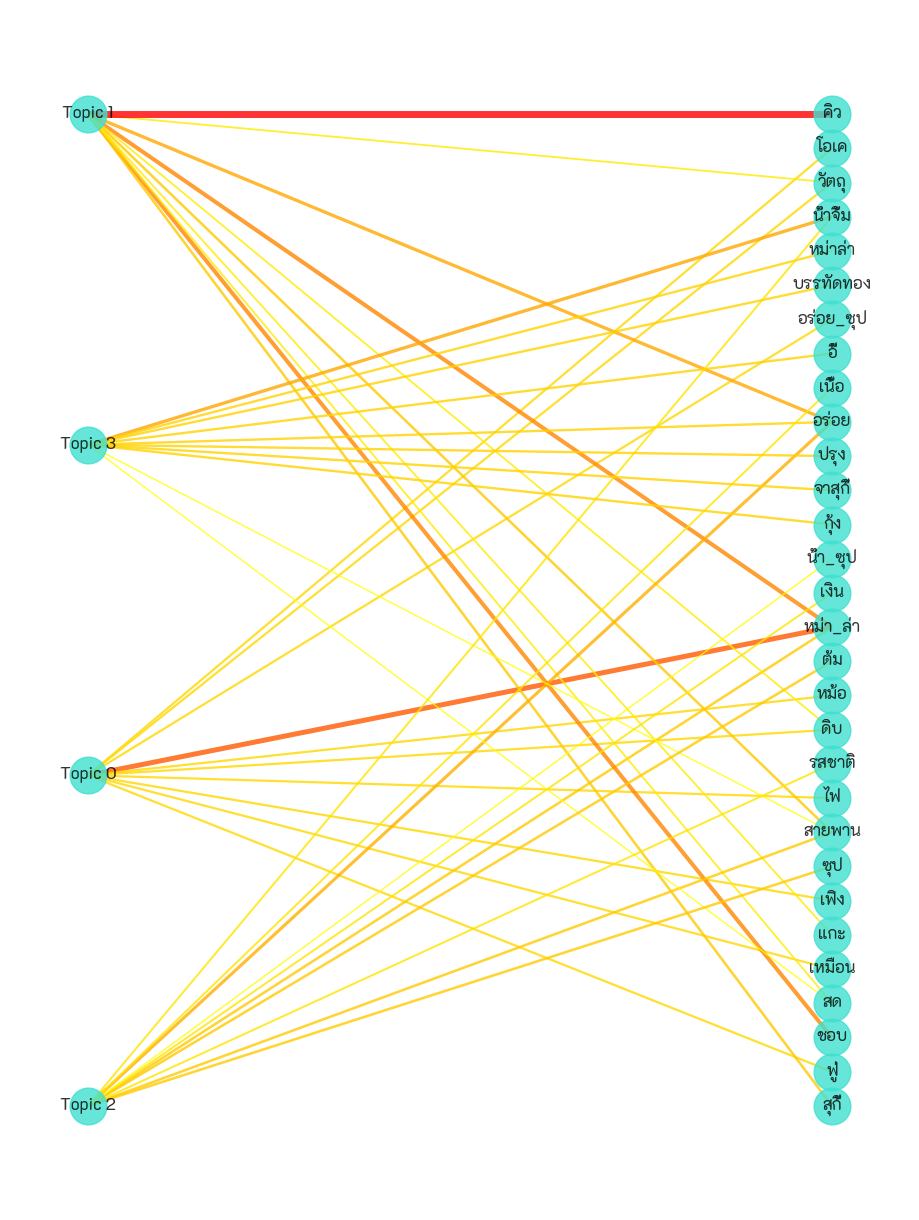

In [66]:
# nodelist, node_size = zip(*[(n,d['support']) for n,d in G.nodes(data=True)])
# node_size = 150 + ((np.array(node_size) - min(node_size)) / (max(node_size) - min(node_size)))*1200
topic_nodes = [ f"Topic {i}" for i in range(num_topics)]
edgelist, weights = zip(*[((u,v), d['weight']) for u,v,d in G.edges(data=True)])


width = 1 + ((np.array(weights) - min(weights)) / (max(weights) - min(weights)))*4

labels_params = {'font_family': 'K2D', 'alpha':.8, 'font_size':12}

plt.figure(figsize=(9,12))

# pos = nx.spring_layout(G, k=5, weight='lift', iterations=120, seed=120, scale=2.5)
# pos = nx.spring_layout(G, k=5, weight='weight', iterations=80, seed=90, scale=2.5)
pos = nx.bipartite_layout(G, topic_nodes)
nx.draw(G, pos, with_labels=True,
        edgelist=edgelist, width=width, edge_color=width, edge_cmap=plt.cm.autumn_r, #edge_color='.75',
        node_color='turquoise', node_size=700,
        **labels_params)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='tomato',  **labels_params)

# plt.title('Association Rules of 1-itemsets')
# plt.savefig('plots/association-rules-1.jpg', dpi=120)
plt.show()